In [1]:
import numpy as np
import math
import time
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.transforms as transform

import audioDataloader.dataloader as dataloader
from audioDataloader.transforms import mulawnEncode,mulaw,array2tensor,dic2tensor,injectNoise,normalizeDim
from paramManager import paramManager

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [3]:
# Read/write directory parameters
#*************************************
datadir = 'data/synth64_76/dataset'
paramdir = 'data/synth64_76/dataparams'
savemodeldir = 'model'
loadmodelpath = 'model/2018-10-12_20-14-50_model_epoch1_step2100.pth'

# Pytorch parameters
#*************************************
#--- Note all intervals below are counted in no. of steps. 1 epoch = [len(dataset)//batch_size] steps ---

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
savemodel = True
savemodel_interval = 100  #If 0 (and savemodel=True) will only save model at the end of entire training
loadmodel = True

# Training parameters
#*************************************
sr = 16000
seqLen = 256
stride = 10
batch_size = 256
num_epochs = 1
lr = 0.005
log_interval = 50
max_steps = 2000 #set max_steps > (len(dataset)//batch_size) if training for more than 1 epoch

#Generation parameters
#*************************************
max_length = seqLen*3
evaluate_interval = 100

In [4]:
# Let's check out the available conditional parameters first
#*************************************
pm = paramManager.paramManager(datadir, paramdir)
datafiles = pm.filenames(datadir)
params = pm.getParams(datafiles[0]) 
print(params.keys())

#note midiPitch has to be scaled since the large raw values interfere with the learning

dict_keys(['meta', 'instID', 'amplitude', 'midiPitch'])


In [5]:
# Initialize dataset & dataloader
#*************************************
audiocoding = mulawnEncode(256,0,1) #initialize the mu-law encodings
targetcoding = mulaw(256)
rescalePitch = normalizeDim('midiPitch',64,76)
rescaleAmp = normalizeDim('amplitude',0,0.9)

adataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID','amplitude','midiPitch'],
                                  transform=transform.Compose([injectNoise(weight=0.1),audiocoding,array2tensor(torch.FloatTensor)]),
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([targetcoding,array2tensor(torch.LongTensor)]))

testdataset = dataloader.AudioDataset(sr,seqLen,stride,
                                  datadir=datadir,extension='wav',
                                  paramdir=paramdir,prop=['instID','amplitude','midiPitch'],
                                  transform=transform.Compose([array2tensor(torch.FloatTensor)]), 
                                  param_transform=transform.Compose([rescaleAmp,rescalePitch,dic2tensor(torch.FloatTensor)]),
                                  target_transform=transform.Compose([array2tensor(torch.LongTensor)]))

train_loader = torch.utils.data.DataLoader(dataset=adataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=4,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=1, 
                                          shuffle=True,
                                          num_workers=4,
                                          drop_last=True)

size of dataset is 1248000
no. of steps per epoch is 4875
(256, 1)


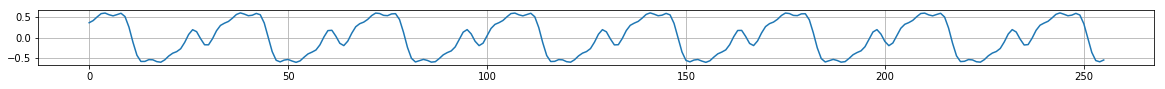

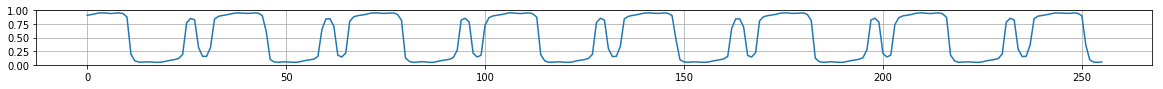

In [12]:
print("size of dataset is",len(adataset))
print("no. of steps per epoch is",len(adataset)//batch_size)

samp = adataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = audiocoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

In [7]:
# Specify the model
#*************************************
class RNN(nn.Module):
    # input size - the number of "classes"
    def __init__(self, input_size, cond_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.cond_size = cond_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers #no. of stacked GRU layers

        self.i2h = nn.Linear(input_size+cond_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    

    # input and cv are each one sequence element 
    def forward(self, input, hidden, batch_size=1):
        #print("input size is " + str((input.size())))
        
        h1 = self.i2h(input)
        #print("size of h1 is " + str(h1.size()))
        
        h_out, hidden = self.gru(h1.view(batch_size,1,-1), hidden)
        #print("h_out"+str(h_out.size()))
        
        output = self.decoder(h_out.view(batch_size,-1))
        #print("output2"+str(output.size()))
        
        return output, hidden

    # initialize hiddens for each minibatch
    def init_hidden(self,batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, dtype=torch.float, device=device)

In [8]:
# Define the training cycle (100% teacher forcing for now)
#*************************************
def train(model,epoch):
    model.train() #put in training mode
    ave_loss_over_steps = 0
    
    for step, (inp,target) in enumerate(train_loader):
        inp, target = inp.to(device), target.to(device)

        # Forward + Backward + Optimize
        hidden = model.init_hidden(batch_size)
        optimizer.zero_grad()
        loss = 0
        
        for i in range(seqLen):
            outputs, hidden = model(inp[:,i,:],hidden,batch_size)  #input dim: (batch, seq, feature)
            loss += criterion(outputs, torch.squeeze(target[:,i],1))
            
        loss.backward()
        optimizer.step()
        
        ave_loss_per_sample = loss.item()/seqLen   #over each minibatch
        ave_loss_over_steps += ave_loss_per_sample
        
        if (step+1) % log_interval == 0:
            print ('{:%Y-%m-%d %H:%M:%S} Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}'.format( 
                datetime.now(), epoch+1, num_epochs, step+1, len(adataset)//batch_size, ave_loss_over_steps/log_interval))
            
            list_of_losses.append(ave_loss_over_steps/log_interval)
            ave_loss_over_steps = 0
            
        if (step+1) % evaluate_interval == 0:
            result = generate(model,max_length)
            plt.figure(figsize=(20,1)) 
            plt.plot(np.arange(len(result)), result) #just print one example from the batch
            plt.show()
            model.train() #put model back to training mode
            
        if (step+1) % savemodel_interval == 0 and savemodel and savemodel_interval != 0:
            torch.save(model.state_dict(), 
               '{}/{:%Y-%m-%d_%H-%M-%S}_model_epoch{}_step{}.pth'.format(savemodeldir,datetime.now(),epoch+1,step+1))
            print('model saved at epoch{} step{}'.format(epoch+1,step+1))
        
        if step==max_steps:
            break
        
        
def generate(model,max_length,primer=None,paramvect=None):
    """primer is not None condition, paramvect is incomplete""" 
    model.eval()
    with torch.no_grad():
        if primer is not None:
            seq = primer
            p_inp = array2tensor(torch.FloatTensor)(audiocoding(primer))
        else:
            for p_inp,target in test_loader:
                seq = np.copy(p_inp[0,:,0])  #extract the original sample
                seq_mu = audiocoding(seq)  #mu-law
                p_inp[0,:,0] = array2tensor(torch.FloatTensor)(seq_mu) #now we have both the original and mu-lawed samples
                break   
        generated = seq
        p_inp = p_inp.to(device)
        #print("p_inp",p_inp)

        hidden = model.init_hidden()
        for j in range(seqLen-1):  #build up hidden state
            _, hidden = model(p_inp[:,j,:],hidden)
        inp = p_inp[:,-1,:]  #feed the last value as the initial value of the actual generation
        #print("inp",inp)
        
        for i in range(max_length):
            outputs, hidden = model(inp,hidden)
            outputs = nn.functional.log_softmax(outputs,dim=1)
            topv, topi = outputs.detach().topk(1)  #choose the strongest activation
            #print(topv,topv.shape)
            #print(topi,topi.shape)
            predicted_sample = targetcoding.index2float(topi)
            
            generated = np.append(generated,predicted_sample)
            
            inp[:,0] = torch.from_numpy(audiocoding([predicted_sample])).type(torch.cuda.FloatTensor)
            if paramvect is not None:
                inp[:,1:] = paramvect
                                       
        return generated
        

In [9]:
# Initialize the network, optimizer and objective func
#*************************************
rnn = RNN(input_size=1,cond_size=3,hidden_size=40,output_size=256,n_layers=4).to(device)
if loadmodel: # load checkpoint if needed
    print("Loading existing checkpoint...")
    rnn.load_state_dict(torch.load(loadmodelpath))
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Loading existing checkpoint...


2018-10-12 20:17:33 Starting training...
2018-10-12 20:19:46 Epoch [1/1], Step [50/4875] Loss: 2.7331
2018-10-12 20:21:43 Epoch [1/1], Step [100/4875] Loss: 1.8003


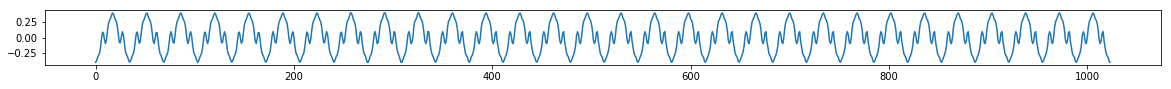

model saved at epoch1 step100
2018-10-12 20:23:48 Epoch [1/1], Step [150/4875] Loss: 1.7620
2018-10-12 20:25:56 Epoch [1/1], Step [200/4875] Loss: 1.7614


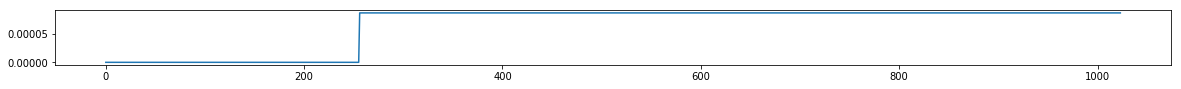

model saved at epoch1 step200
2018-10-12 20:28:08 Epoch [1/1], Step [250/4875] Loss: 1.7533
2018-10-12 20:30:22 Epoch [1/1], Step [300/4875] Loss: 1.7413


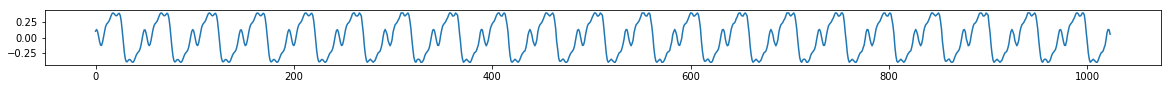

model saved at epoch1 step300
2018-10-12 20:32:43 Epoch [1/1], Step [350/4875] Loss: 1.7296
2018-10-12 20:34:51 Epoch [1/1], Step [400/4875] Loss: 1.7153


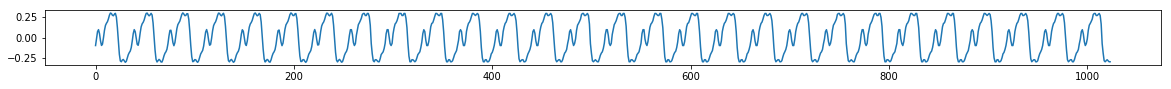

model saved at epoch1 step400
2018-10-12 20:37:04 Epoch [1/1], Step [450/4875] Loss: 1.7381
2018-10-12 20:39:12 Epoch [1/1], Step [500/4875] Loss: 1.7544


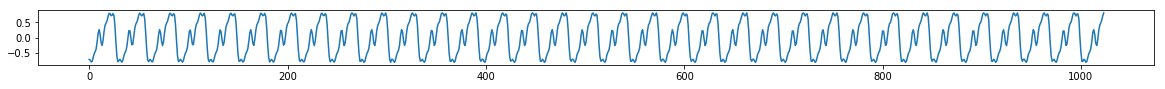

model saved at epoch1 step500
2018-10-12 20:41:27 Epoch [1/1], Step [550/4875] Loss: 1.7181
2018-10-12 20:43:34 Epoch [1/1], Step [600/4875] Loss: 1.7079


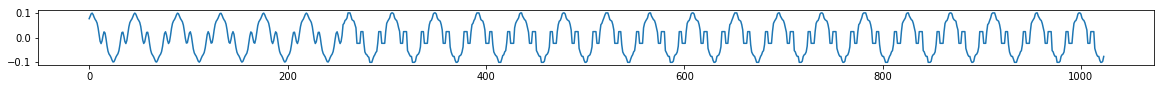

model saved at epoch1 step600
2018-10-12 20:45:54 Epoch [1/1], Step [650/4875] Loss: 1.7334
2018-10-12 20:48:00 Epoch [1/1], Step [700/4875] Loss: 1.6824


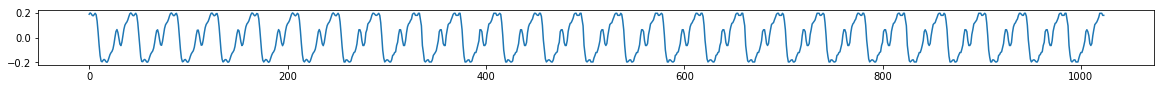

model saved at epoch1 step700
2018-10-12 20:50:15 Epoch [1/1], Step [750/4875] Loss: 1.6993
2018-10-12 20:52:20 Epoch [1/1], Step [800/4875] Loss: 1.7288


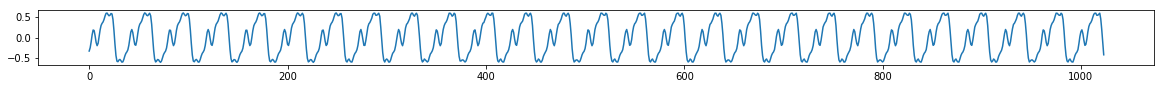

model saved at epoch1 step800
2018-10-12 20:54:28 Epoch [1/1], Step [850/4875] Loss: 1.6841
2018-10-12 20:56:33 Epoch [1/1], Step [900/4875] Loss: 1.6821


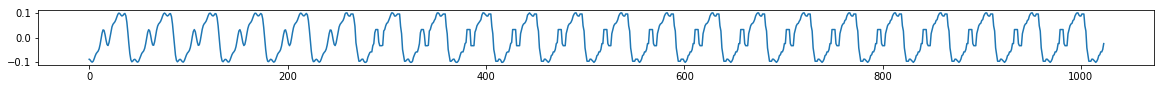

model saved at epoch1 step900
2018-10-12 20:58:42 Epoch [1/1], Step [950/4875] Loss: 1.6757
2018-10-12 21:00:52 Epoch [1/1], Step [1000/4875] Loss: 1.6819


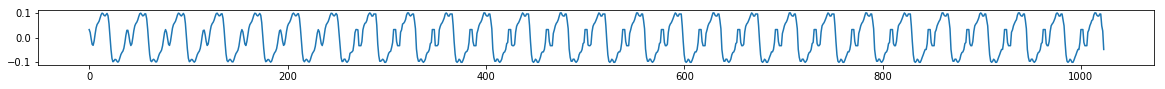

model saved at epoch1 step1000
2018-10-12 21:03:09 Epoch [1/1], Step [1050/4875] Loss: 1.7000
2018-10-12 21:05:18 Epoch [1/1], Step [1100/4875] Loss: 1.6661


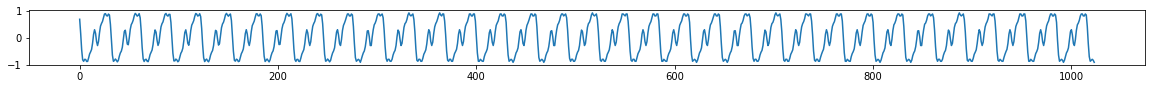

model saved at epoch1 step1100
2018-10-12 21:07:31 Epoch [1/1], Step [1150/4875] Loss: 1.6603
2018-10-12 21:09:35 Epoch [1/1], Step [1200/4875] Loss: 1.6685


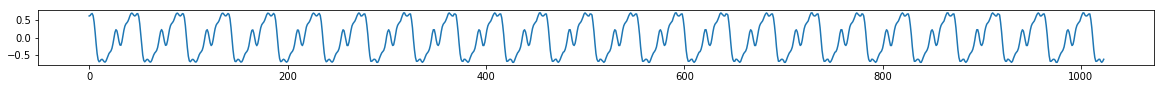

model saved at epoch1 step1200
2018-10-12 21:11:43 Epoch [1/1], Step [1250/4875] Loss: 1.6824
2018-10-12 21:13:45 Epoch [1/1], Step [1300/4875] Loss: 1.6987


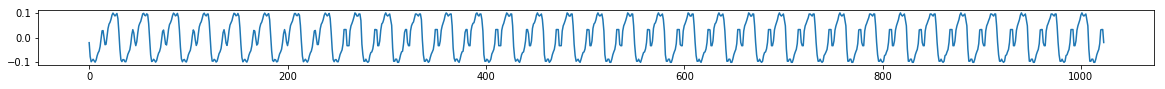

model saved at epoch1 step1300
2018-10-12 21:15:53 Epoch [1/1], Step [1350/4875] Loss: 1.6572
2018-10-12 21:17:56 Epoch [1/1], Step [1400/4875] Loss: 1.7015


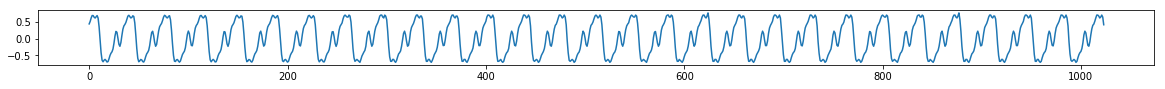

model saved at epoch1 step1400
2018-10-12 21:20:07 Epoch [1/1], Step [1450/4875] Loss: 1.6616
2018-10-12 21:22:07 Epoch [1/1], Step [1500/4875] Loss: 1.6432


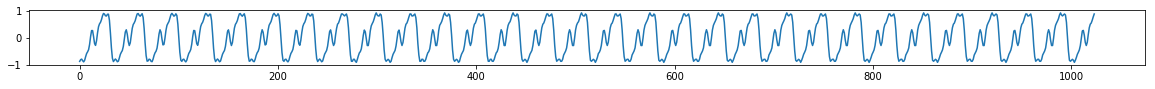

model saved at epoch1 step1500
2018-10-12 21:24:14 Epoch [1/1], Step [1550/4875] Loss: 1.6449
2018-10-12 21:26:18 Epoch [1/1], Step [1600/4875] Loss: 1.6352


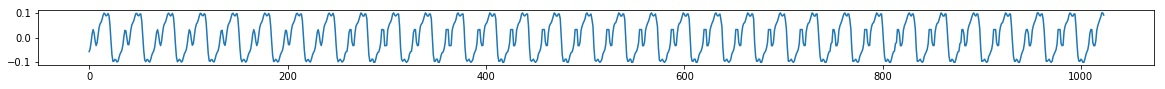

model saved at epoch1 step1600
2018-10-12 21:28:28 Epoch [1/1], Step [1650/4875] Loss: 1.6330
2018-10-12 21:30:32 Epoch [1/1], Step [1700/4875] Loss: 1.6501


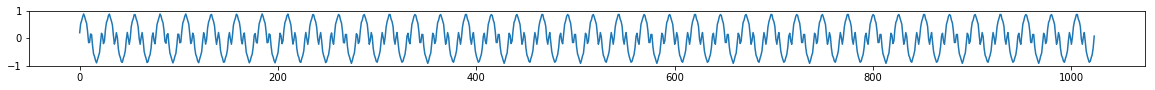

model saved at epoch1 step1700
2018-10-12 21:32:46 Epoch [1/1], Step [1750/4875] Loss: 1.6365
2018-10-12 21:34:49 Epoch [1/1], Step [1800/4875] Loss: 1.6233


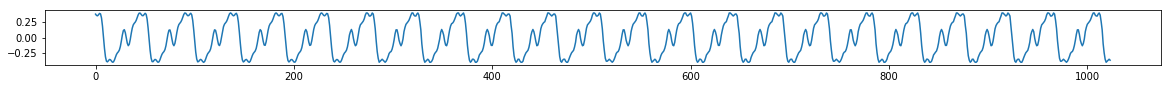

model saved at epoch1 step1800
2018-10-12 21:37:03 Epoch [1/1], Step [1850/4875] Loss: 1.6370
2018-10-12 21:39:08 Epoch [1/1], Step [1900/4875] Loss: 1.6173


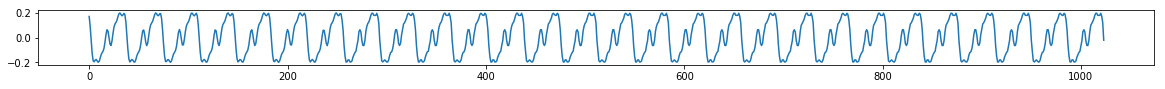

model saved at epoch1 step1900
2018-10-12 21:41:19 Epoch [1/1], Step [1950/4875] Loss: 1.5973
2018-10-12 21:43:21 Epoch [1/1], Step [2000/4875] Loss: 1.6528


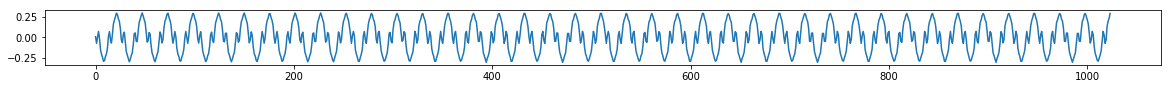

model saved at epoch1 step2000
Training time taken: 1:25:55


In [10]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
for epoch in range(num_epochs):
    train(rnn,epoch)
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

if savemodel_interval == 0 and savemodel:
    torch.save(model.state_dict(), 
       '{}/{:%Y-%m-%d_%H-%M-%S}_model_epoch{}.pth'.format(savemodeldir,datetime.now(),num_epochs))
    print('model saved at epoch{}'.format(num_epochs))

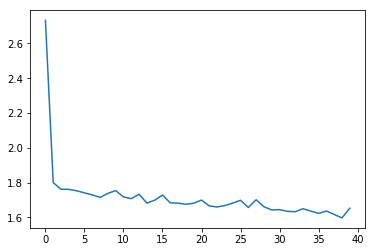

In [11]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)